In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.io import arff
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap

2025-02-20 22:31:18.540947: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.

A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/guilhermemaciel/.lo

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/guilhermemaciel/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/guilhermemaciel/.lo

AttributeError: _ARRAY_API not found

ImportError: numpy.core._multiarray_umath failed to import

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

## 1. Coleta Inicial de Dados

### Colab

In [4]:
#file_path = "/content/drive/MyDrive/SI5/electricity-normalized.arff"
#data, meta = arff.loadarff(file_path)

#df = pd.DataFrame(data)

### Local

In [5]:
file_path = "data/raw/electricity-normalized.arff"
data, meta = arff.loadarff(file_path)

df = pd.DataFrame(data)

### Converter colunas categóricas de bytes para strings


In [6]:
for col in df.select_dtypes([object]):
    df[col] = df[col].str.decode("utf-8")

## 2. Descrição dos dados

### Descrição das variáveis

- date: Data da coleta da informação
- day: Dia da semana
- period: Período do Dia
- nswprice: Consumo de eletricidade em NSW
- nswdemand: Demanda de eletricidade em Nova Gales do Sul (NSW)
- vicdemand: Demanda de eletricidade em Victoria
- vicprice: Consumo de eletricidade em Victoria
- transfer: Transferências programadas entre os estados
- class: Classe alvo

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45312 entries, 0 to 45311
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       45312 non-null  float64
 1   day        45312 non-null  object 
 2   period     45312 non-null  float64
 3   nswprice   45312 non-null  float64
 4   nswdemand  45312 non-null  float64
 5   vicprice   45312 non-null  float64
 6   vicdemand  45312 non-null  float64
 7   transfer   45312 non-null  float64
 8   class      45312 non-null  object 
dtypes: float64(7), object(2)
memory usage: 3.1+ MB


Toda esses atributos, com exceção da classe alvo (Class) e do dia da semana (Day) são variáveis contínuas já normalizadas com valores que variam de 0 a 1.

A coluna day, possui valores categóricos em formato numérico que variam de 1 a 7 (referentes ao dia da semana). Para a classe alvo, temos as strings UP, informando que o preço subiu em relação a última medição e Down, informando que houve uma queda no preço.

In [8]:
df.describe()

,date,period,nswprice,nswdemand,vicprice,vicdemand,transfer
count,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000
mean,0.499080,0.500000,0.057868,0.425418,0.003467,0.422915,0.500526
std,0.340308,0.294756,0.039991,0.163323,0.010213,0.120965,0.153373
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.031934,0.250000,0.035127,0.309134,0.002277,0.372346,0.414912
50%,0.456329,0.500000,0.048652,0.443693,0.003467,0.422915,0.414912
75%,0.880547,0.750000,0.074336,0.536001,0.003467,0.469252,0.605702
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Inicialmente, realizamos uma análise superficial das variáveis do conjunto de dados, a fim de se obter noções iniciais. Embora os dados estejam normalizados, é possível observar o preço médio para a cidade NSW é maior que para a cidade victoria, mesmo que a demanda seja extremamente parecida para ambas as cidades. 

In [9]:
df.isnull().sum()

date         0
day          0
period       0
nswprice     0
nswdemand    0
vicprice     0
vicdemand    0
transfer     0
class        0
dtype: int64

A análise preliminar do dataset revelou uma qualidade consistente na coleta dos dados, uma vez que nenhuma das features apresenta valores nulos. Isso elimina a necessidade de aplicar algoritmos de substituição de dados ausentes, facilitando o pré-processamento e garantindo maior integridade na análise.

## 3. Exploração dos dados

### Distribuição das Variáveis Categóricas

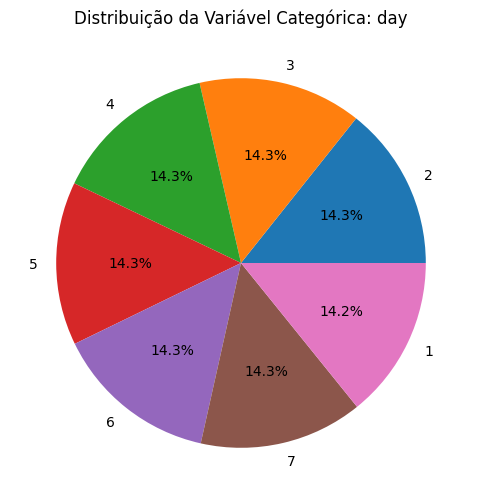

In [10]:
plt.figure(figsize=(6, 6))
df['day'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title(f"Distribuição da Variável Categórica: day")
plt.ylabel('')
plt.show()

A primeira variável categórica do dataset é "day", que representa o dia da semana em que a coleta foi realizada. Essa variável assume valores de 1 a 7 e apresenta uma distribuição equilibrada, indicando que os dados foram coletados de forma homogênea ao longo da semana.

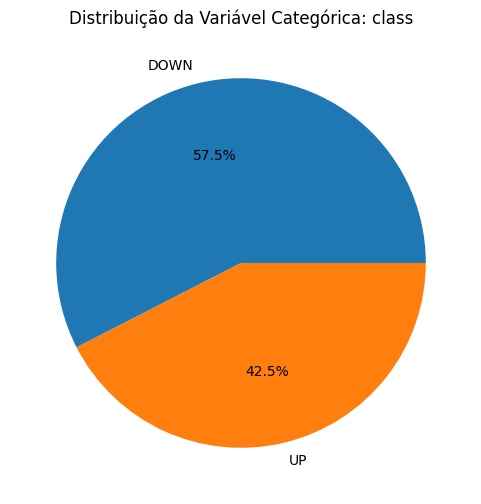

In [11]:
plt.figure(figsize=(6, 6))
df['class'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title(f"Distribuição da Variável Categórica: class")
plt.ylabel('')
plt.show()

A outra variável categórica presente no dataset é "class" (classe alvo do dataset), que indica se houve uma variação de preço em relação à última coleta. A análise da distribuição revela que os dados estão parcialmente equilibrados, com 57,5% pertencendo a uma classe e 42,5% à outra. Observamos uma leve tendência maior para a classe "DOWN", indicando uma prevalência de quedas de preço.

No entanto, como se trata de uma variável categórica, ela não fornece informações sobre a magnitude da variação, apenas sinaliza sua ocorrência. Em análises futuras, aprofundaremos a investigação sobre a amplitude dessas mudanças de preço.

### Distribuição das Variáveis Contínuas

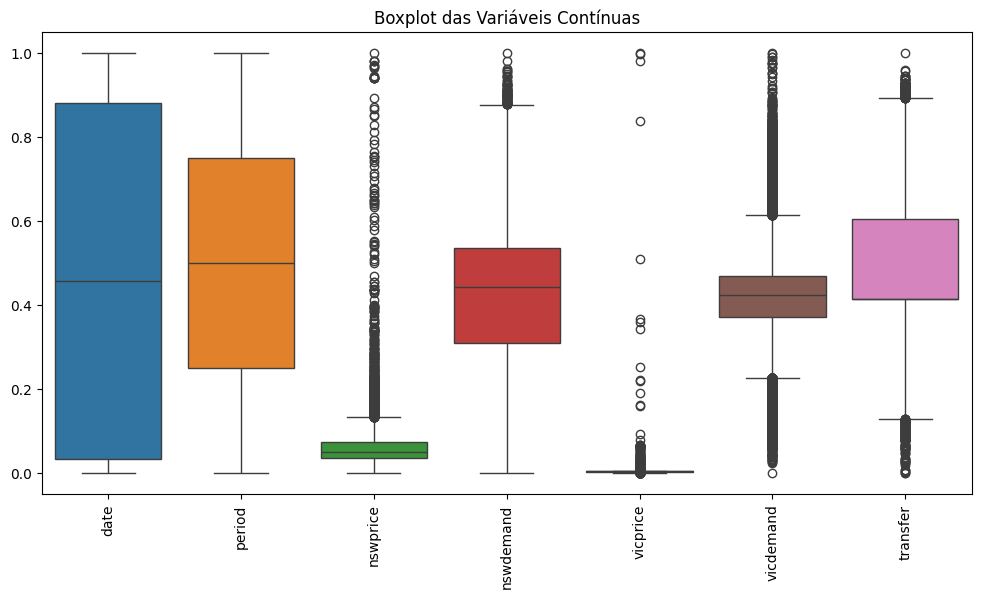

In [12]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df)
plt.title("Boxplot das Variáveis Contínuas")
plt.xticks(rotation=90)
plt.show()

O dataset possui sete variáveis contínuas já normalizadas, eliminando a necessidade de escalonamento adicional e garantindo uma escala padronizada. No entanto, a falta dos dados originais (antes da normalização) dificulta a identificação de outliers, a interpretação da distribuição e pode mascarar padrões importantes, impactando análises e modelos preditivos.

### Identificando Outliers

In [13]:
# Filtra apenas as colunas numéricas
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Calcula Q1, Q3 e IQR para cada coluna numérica
Q1 = df[numerical_cols].quantile(0.25)
Q3 = df[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

# Detecta outliers
outliers = ((df[numerical_cols] < (Q1 - 1.5 * IQR)) | (df[numerical_cols] > (Q3 + 1.5 * IQR))).sum()
outliers

date            0
period          0
nswprice      890
nswdemand      83
vicprice     3683
vicdemand    6052
transfer      420
dtype: int64

### Histogramas para variáveis contínuas


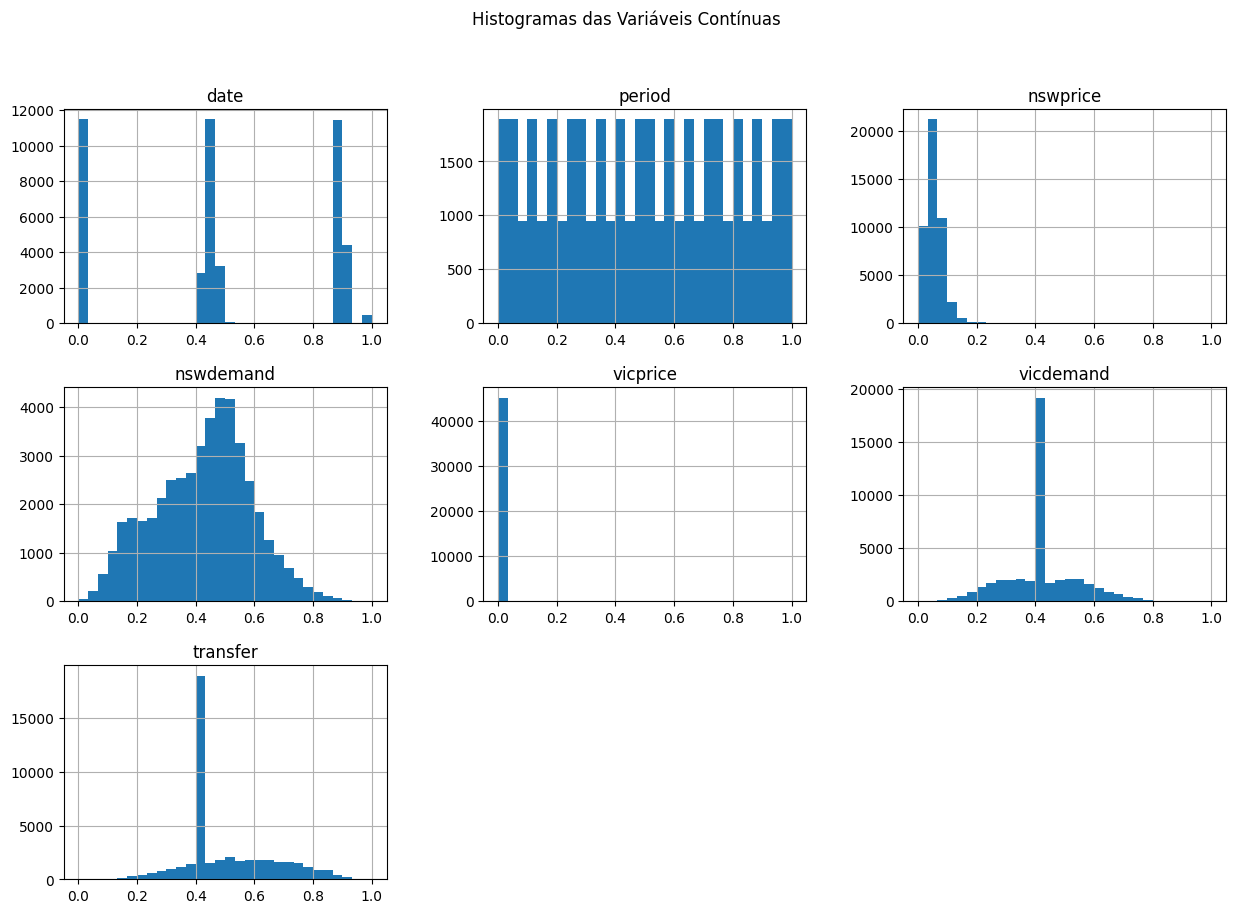

In [14]:
df.hist(bins=30, figsize=(15, 10))
plt.suptitle("Histogramas das Variáveis Contínuas")
plt.show()

### Gráficos comparativos para distribuição dos dados entre as diferentes classes


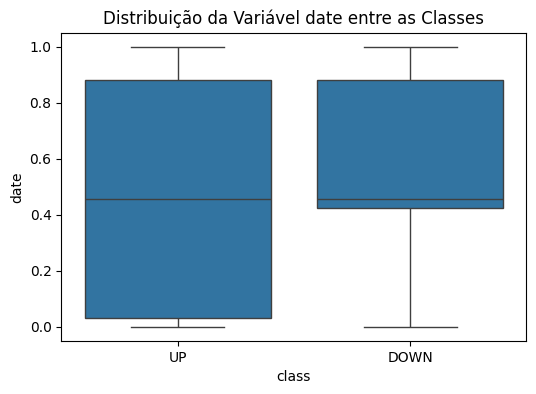

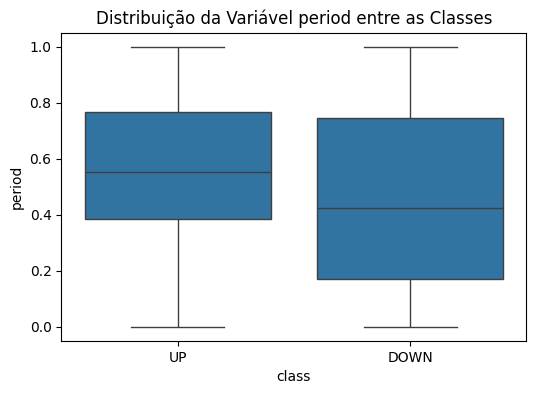

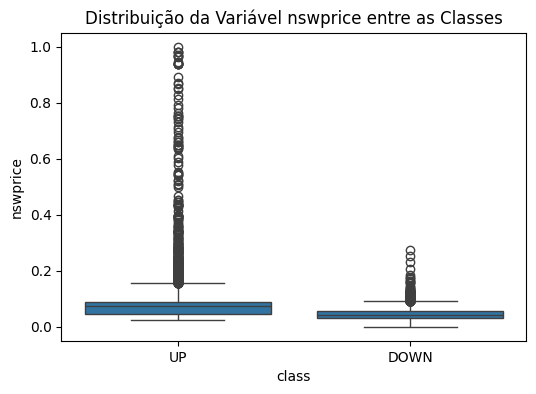

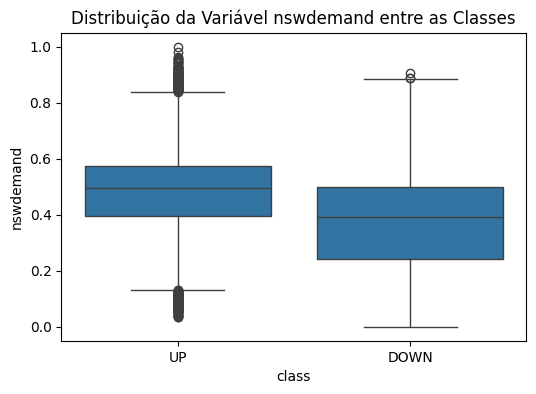

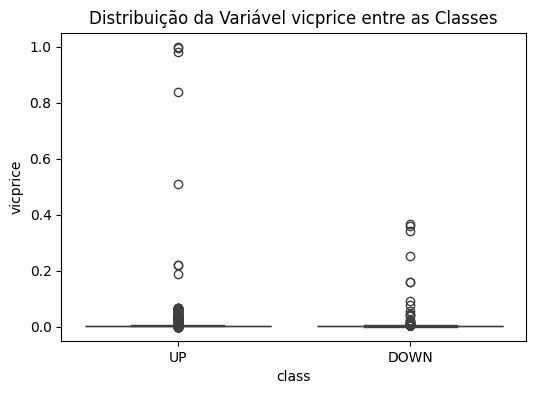

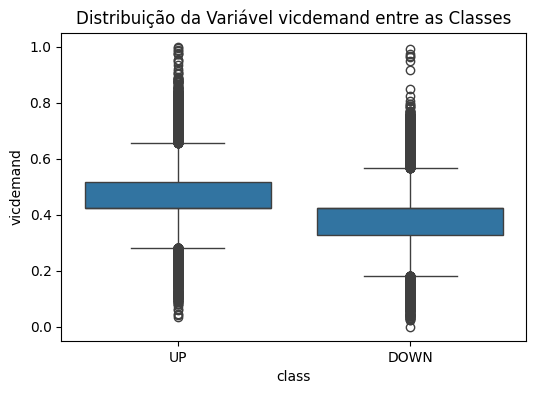

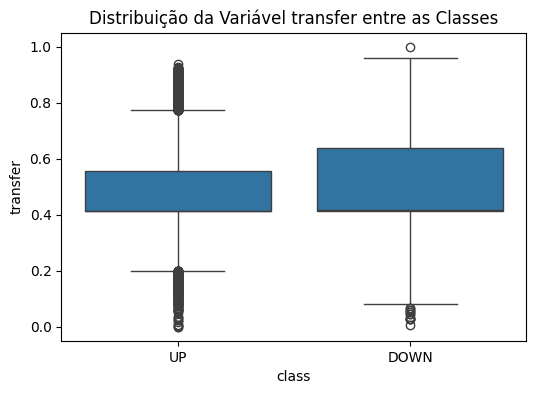

In [15]:
for col in df.select_dtypes(include=[np.number]).columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df['class'], y=df[col])
    plt.title(f"Distribuição da Variável {col} entre as Classes")
    plt.show()

## 4. Verificação da qualidade dos dados

### Matriz de Correlação

Abaixo apresentamos a matriz de correlação entre as features com a classe alvo, onde cada célula representa o coeficiente de correlação de Pearson entre duas variáveis numéricas.

In [16]:
df['class'] = df['class'].apply(lambda val: 1 if val == 'UP' else 0)

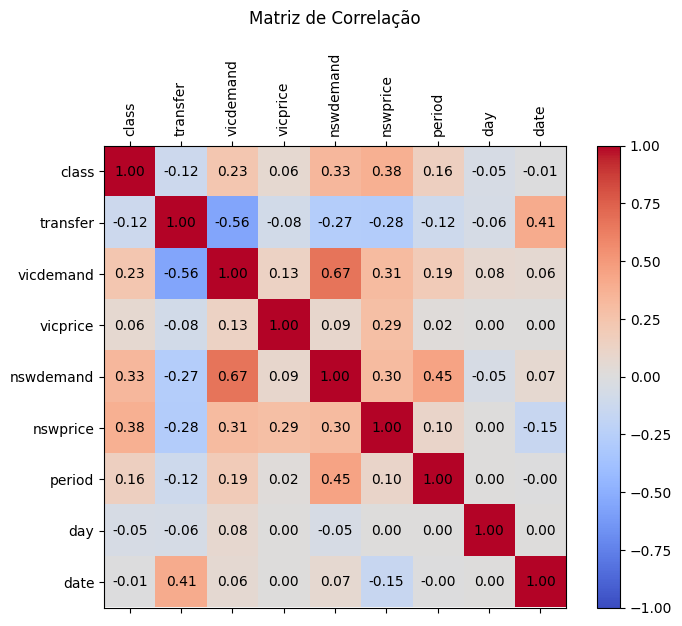

In [17]:
corr = df.corr().iloc[::-1, ::-1]

fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)

fig.colorbar(cax)

for (i, j), val in np.ndenumerate(corr):
    ax.text(j, i, f"{val:.2f}", ha='center', va='center', color='black')


ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns)
ax.set_yticklabels(corr.columns)

plt.xticks(rotation=90)

plt.title("Matriz de Correlação", pad=20)
plt.show()

Observa-se uma correlação positiva forte entre nswdemand e vicdemand (0.67) e uma correlação moderada entre nswprice e vicdemand (0.31), indicando que a demanda em diferentes regiões pode estar relacionada e que os preços podem ter influência na quantidade demandada

Em contrapartida, há uma correlação negativa significativa entre transfer e vicdemand (-0.56), sugerindo que transferências entre regiões afetam negativamente a demanda. Sugerindo que transferências entre regiões afetam negativamente a demanda, uma vez que uma demanda mas baixa há a tendência de sobrar energia e consequentemente a transferência de energia entre as cidades tende a aumentar.

Por fim, as features Day e date, apresentam valores próximos de zero para outras colunas, indicando ausência de relação linear clara, principalmente com a varável alvo, o que pode indicar que elas não possuem relevância na classificação se o preço irá subir ou descer. 

### Valores das Variáveis Contínuas ao longo do tempo

Para essa análise, buscamos entender como o preço, a demanda e a transferência da energia máximos de um dia variam de acordo com o tempo. Essa análise é importante para detectar padrões nos dados, bem como entender sua distribuição e valores ao longo do mês.

É possível observar uma correlação alta entre preço e demanda, quando o preço sobe no seu gráfico a demanda para o mesmo período tende a ser alta também. Isso corrobora com a lógica de mercado em que vivemos, em que a medida em que a demanda por energia cresce, o seu preço logicamente acompanha esse crescimento.

In [18]:
list_features = ['nswprice', 'nswdemand', 'vicprice', 'vicdemand', 'transfer']

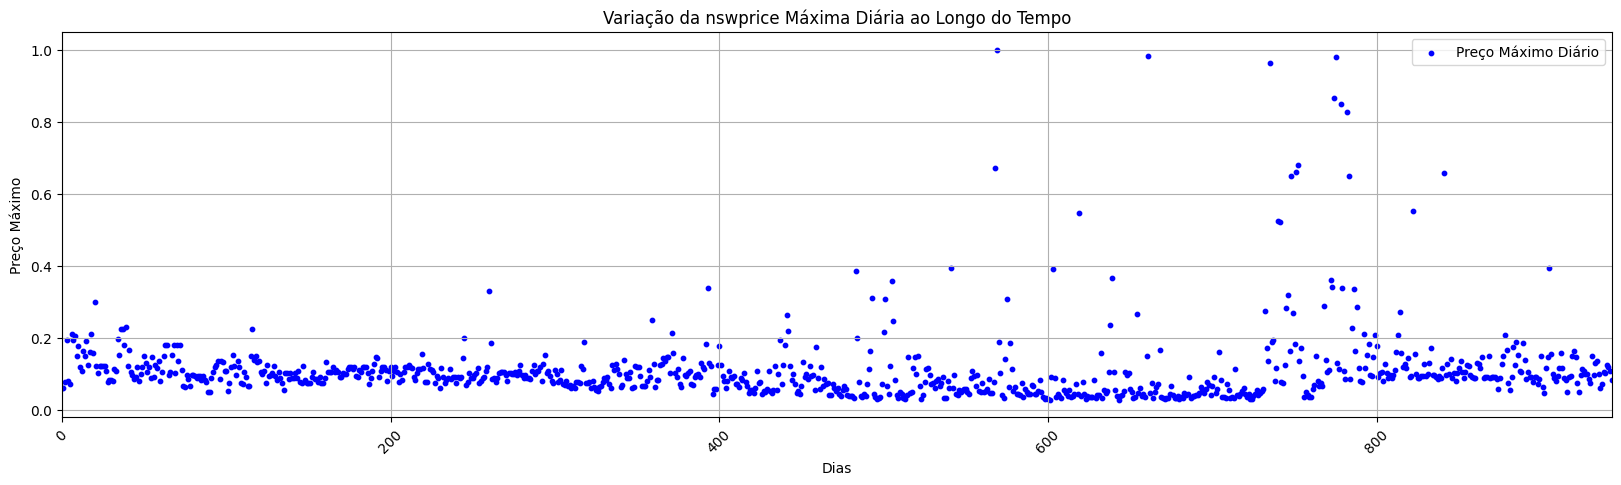

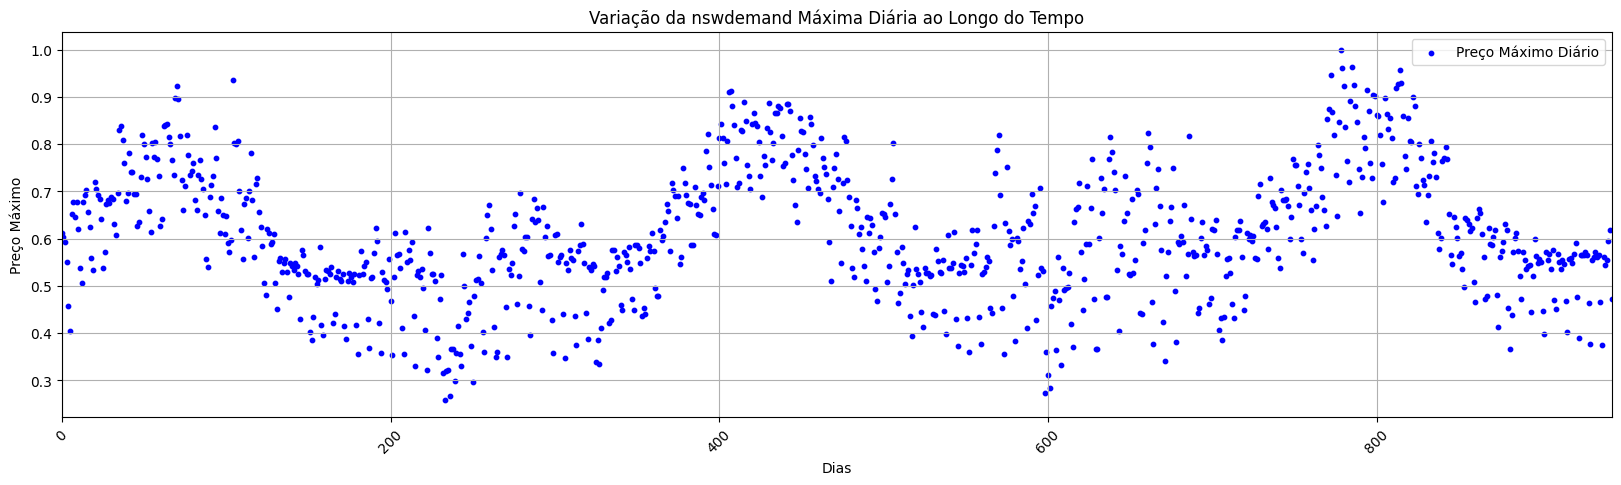

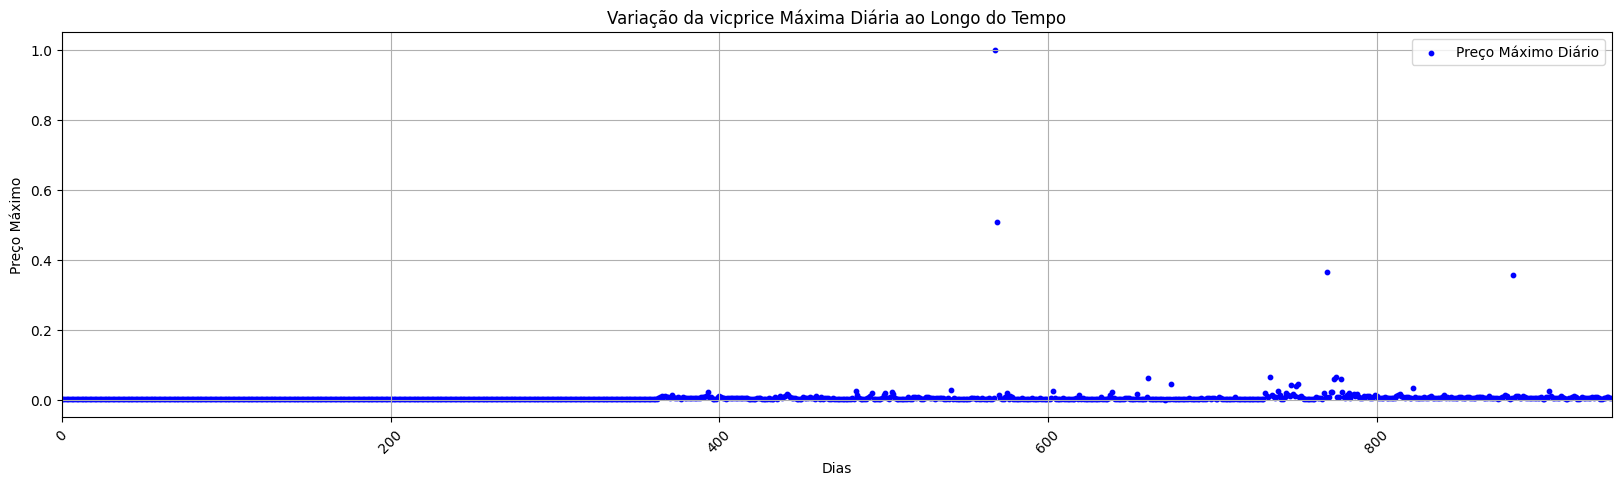

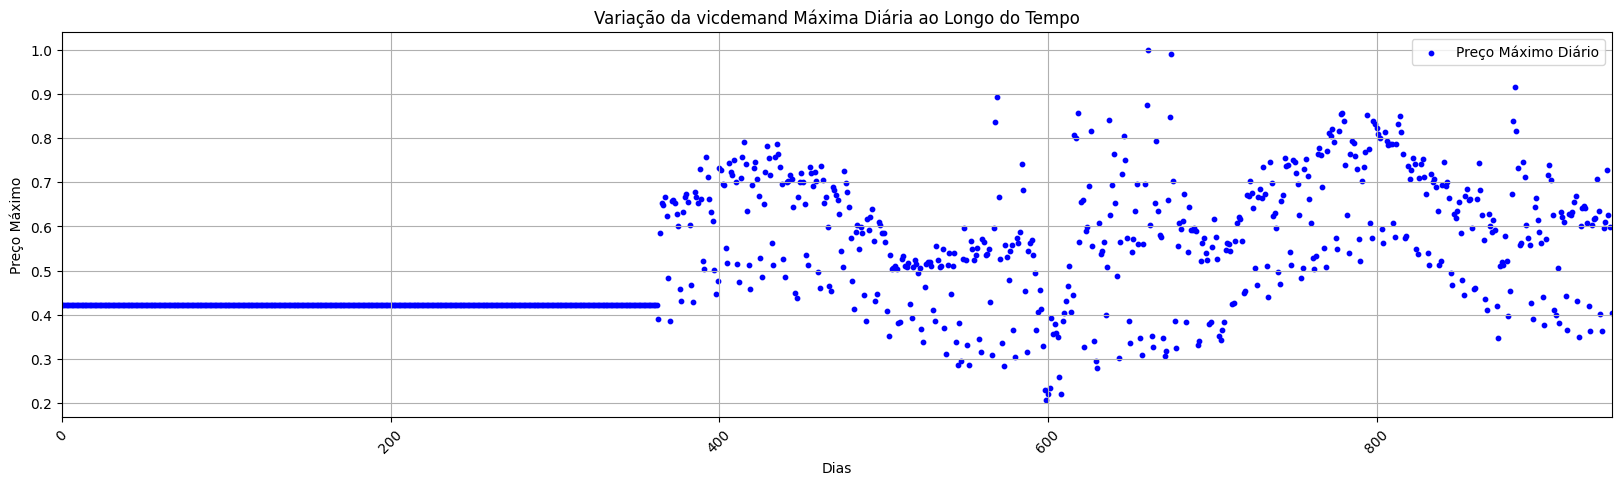

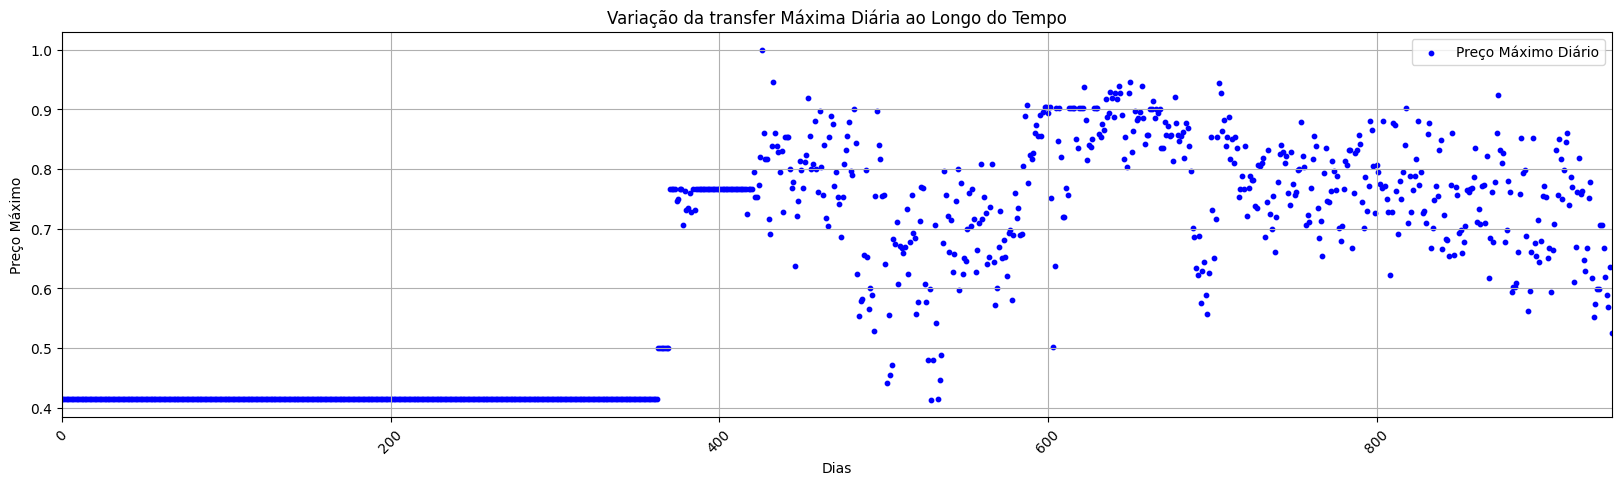

In [19]:
for variavel in list_features:
    precos_maximos_diarios = []
    medicoes_por_dia = 48
    
    for i in range(0, len(df), medicoes_por_dia):
        max_diario = df[variavel][i:i+medicoes_por_dia].max()
        precos_maximos_diarios.append(max_diario)


    dias = np.arange(len(precos_maximos_diarios))

    # Criar o gráfico de dispersão
    plt.figure(figsize=(20, 5))
    plt.scatter(dias, precos_maximos_diarios, color='b', label='Preço Máximo Diário', s=10)

    # Label do gráfico
    plt.xlabel('Dias')
    plt.ylabel('Preço Máximo')
    plt.title(f'Variação da {variavel} Máxima Diária ao Longo do Tempo')

    plt.xticks(rotation=45)
    plt.xlim(min(dias), max(dias))
    plt.legend()
    plt.grid()
    plt.show()

### Valores das Variáveis Contínuas por dia da semana

Nesta etapa, veremos como as variáveis contínuas se comportam nos 7 dias da semana.

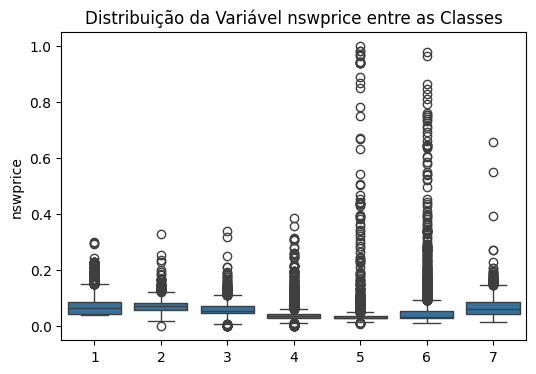

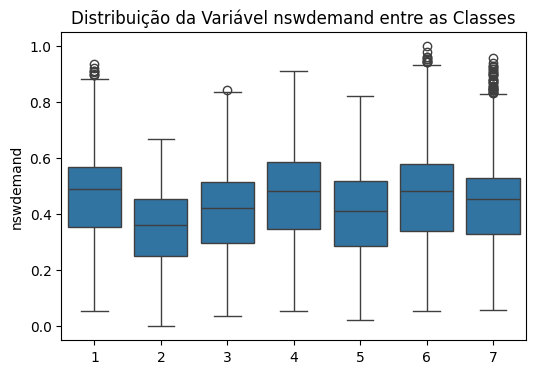

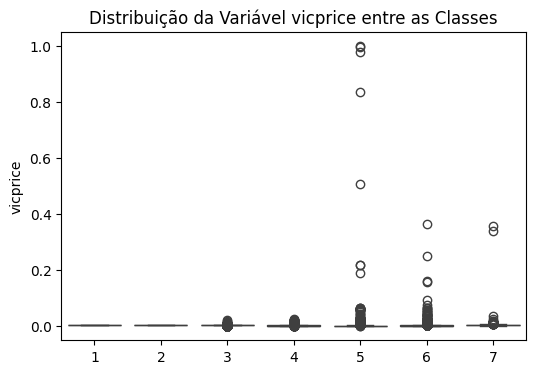

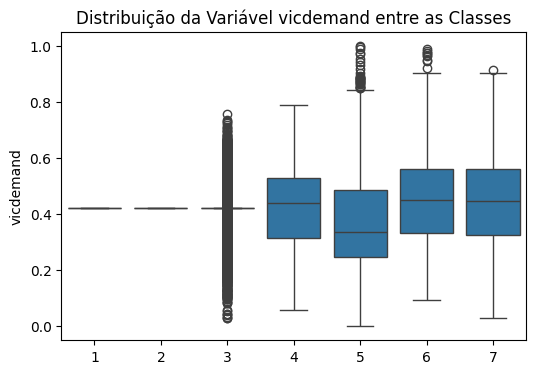

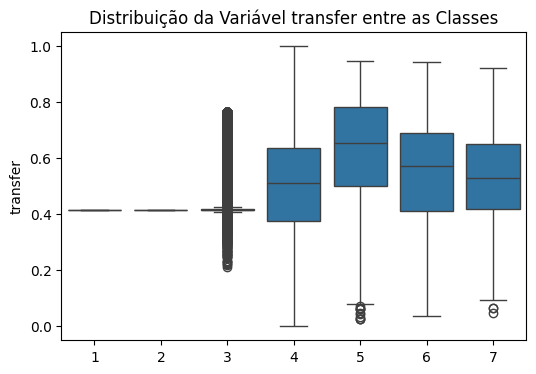

In [20]:
for col in list_features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=sorted(df['day']), y=df[col])
    plt.title(f"Distribuição da Variável {col} entre as Classes")
    plt.show()

### Redução de Dimensionalidade

A redução de dimensionalidade é uma técnica muito interessante no contexto de análise exploratória dos dados, visto que ao lidar com um conjunto de dados com uma grande quantidade de variáveis (dimensões) pode ser difícil a identificação de padrões e a as relações entre as variáveis.

Nesse contexto, resolvemos utilizar 3 técnicas de redução de dimensionalidade para facilitar o processo de exploração dos dados: PCA (Principal Component Analysis), T-SNE (t-Distributed Stochastic Neighbor Embedding) e UMAP (Uniform Manifold Approximation and Projection). Em cada técnica fizemos 2 análises distintas, uma reduzindo os dados para 2 componentes e outra reduzindo os dados para 3 componentes.

In [21]:
df['class'] = df['class'].replace({'UP': 1, 'DOWN': 0})
Y_df = df['class']
X_df = df.drop(columns=['class'])

### t-SNE

In [22]:
tsne_2d = TSNE(n_components=2, random_state=42)
X_tsne = tsne_2d.fit_transform(X_df)

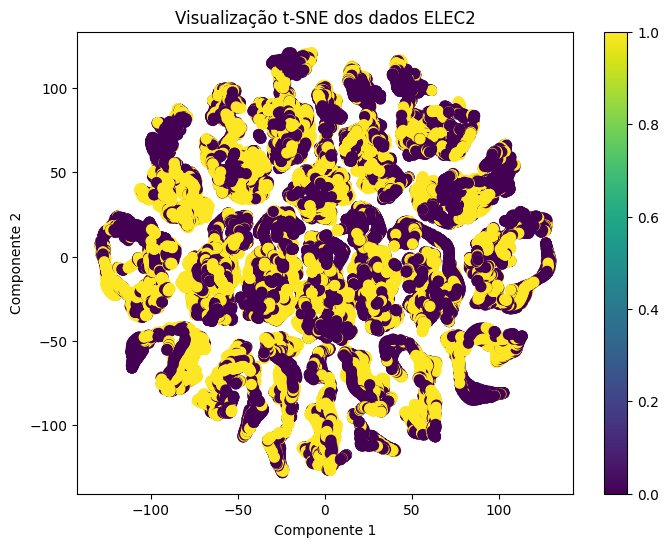

In [23]:
plt.figure(figsize=(8,6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=Y_df, cmap='viridis', s=50)
plt.colorbar()
plt.title("Visualização t-SNE dos dados ELEC2")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.show()

In [24]:
tsne_3d = TSNE(n_components=3, random_state=42)
X_tsne = tsne_3d.fit_transform(X_df)

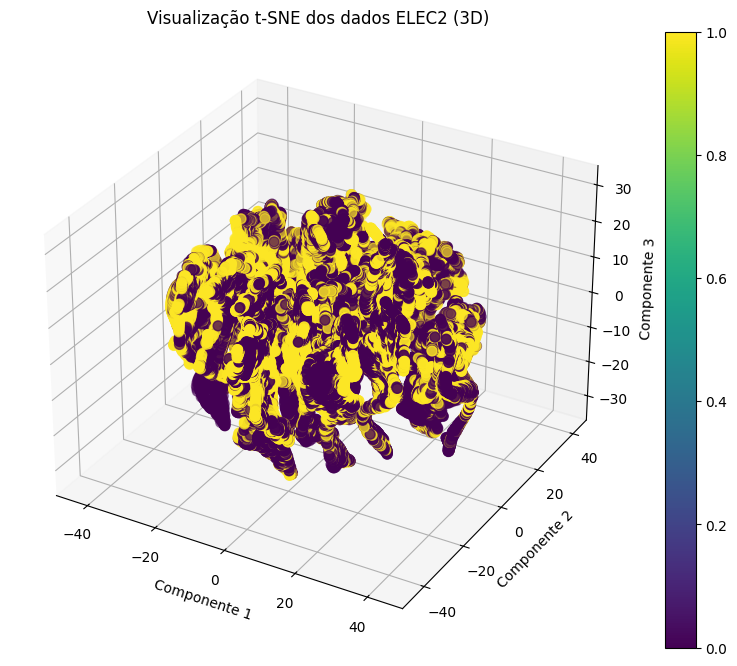

In [25]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=Y_df, cmap='viridis', s=50)
fig.colorbar(scatter)
ax.set_title("Visualização t-SNE dos dados ELEC2 (3D)")
ax.set_xlabel("Componente 1")
ax.set_ylabel("Componente 2")
ax.set_zlabel("Componente 3")
plt.show()

### UMAP

In [26]:
umap_2d = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_2d.fit_transform(X_df)

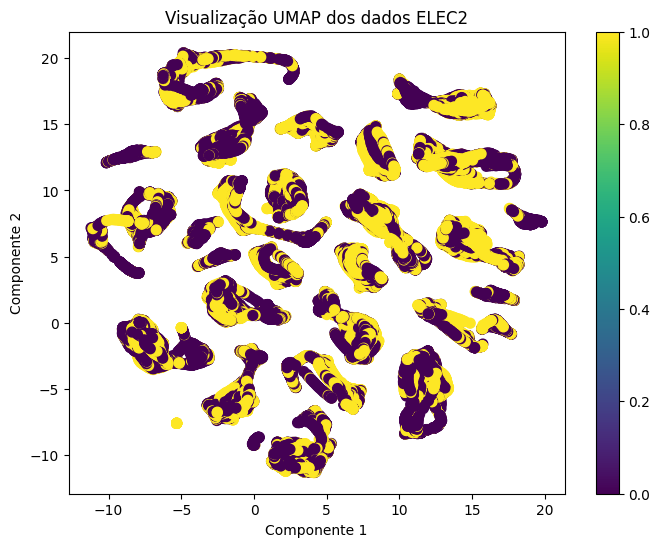

In [27]:
# Plotando os dados reduzidos com t-SNE
plt.figure(figsize=(8,6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=Y_df, cmap='viridis', s=50)
plt.colorbar()
plt.title("Visualização UMAP dos dados ELEC2")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.show()

In [28]:
umap_3d = umap.UMAP(n_components=3, random_state=42)
X_umap = umap_3d.fit_transform(X_df)

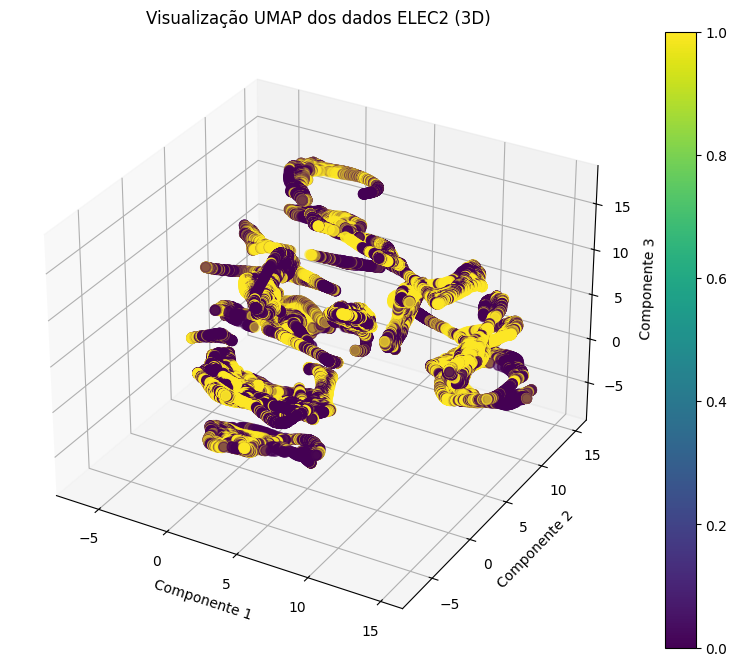

In [29]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_umap[:, 0], X_umap[:, 1], X_umap[:, 2], c=Y_df, cmap='viridis', s=50)
fig.colorbar(scatter)
ax.set_title("Visualização UMAP dos dados ELEC2 (3D)")
ax.set_xlabel("Componente 1")
ax.set_ylabel("Componente 2")
ax.set_zlabel("Componente 3")
plt.show()

### PCA

In [30]:
pca_2d = PCA(n_components=2)
X_pca = pca_2d.fit_transform(X_df)

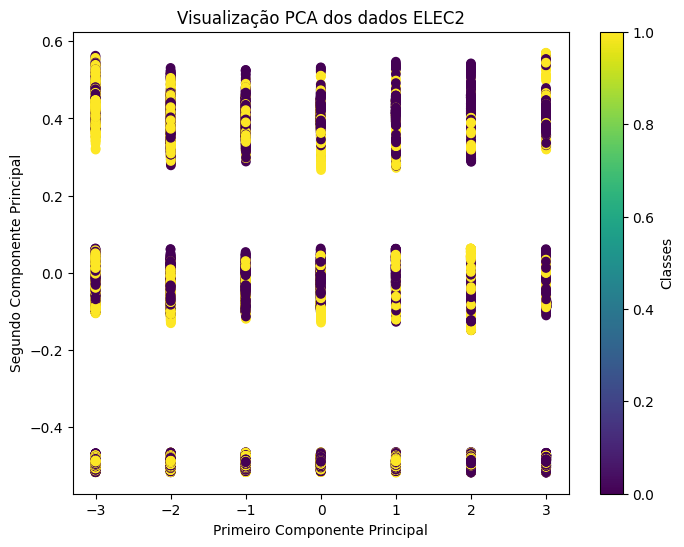

In [31]:
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Y_df, cmap='viridis')
plt.xlabel('Primeiro Componente Principal')
plt.ylabel('Segundo Componente Principal')
plt.title('Visualização PCA dos dados ELEC2')
plt.colorbar(label='Classes')
plt.show()

In [32]:
pca_3d = PCA(n_components=3)
X_pca = pca_3d.fit_transform(X_df)

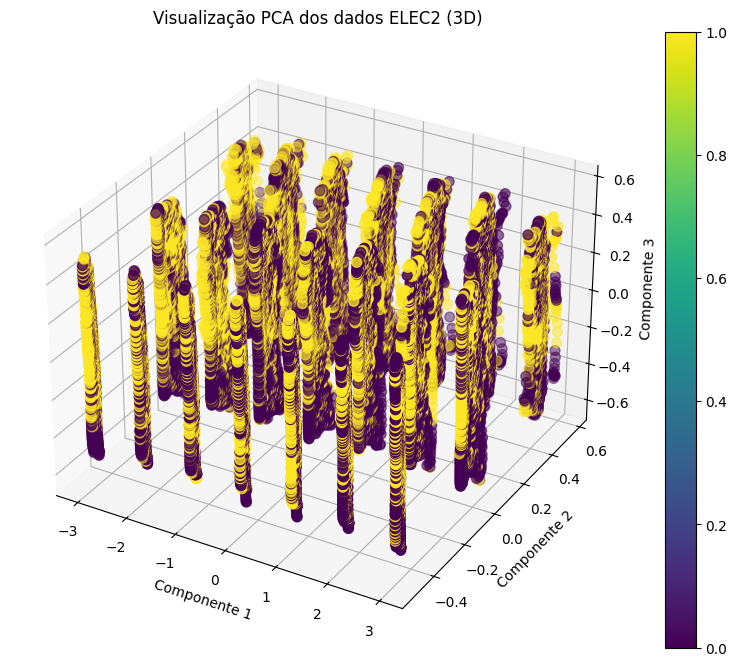

In [33]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=Y_df, cmap='viridis', s=50)
fig.colorbar(scatter)
ax.set_title("Visualização PCA dos dados ELEC2 (3D)")
ax.set_xlabel("Componente 1")
ax.set_ylabel("Componente 2")
ax.set_zlabel("Componente 3")
plt.show()